In [56]:
"""
    Package Installation
"""
__author__ = "SakibApon"
__email__ = "sakibapon7@gmail.com"


import itertools 
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import class_weight
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D,BatchNormalization,Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
train_data_dir = '../input/busi-augmented/Augmented/Augmented/train'
validation_data_dir = '../input/busi-augmented/val'
test_Data_dir='../input/busi-augmented/val'

num_classes = 2
batch_size = 16
img_rows, img_cols = 224, 224
INPUT_SHAPE = (img_rows, img_cols, 3)

train_datagen = ImageDataGenerator(rotation_range=90, zoom_range=0.15, width_shift_range=0.2,
            height_shift_range=0.2, shear_range=30, horizontal_flip=True, fill_mode="nearest")

validation_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_rows, img_cols), batch_size=batch_size, class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory( validation_data_dir, target_size=(img_rows, img_cols), batch_size=batch_size, class_mode='categorical')
test_generator=test_datagen.flow_from_directory( test_Data_dir, target_size=(img_rows, img_cols), batch_size=batch_size, class_mode='categorical')

Found 7839 images belonging to 2 classes.
Found 260 images belonging to 2 classes.
Found 260 images belonging to 2 classes.


In [58]:
l = []
def modelfunction(pretrained, weight):
    
    for layer in pretrained.layers:
        layer.trainable = False
        
    def addTopModel(bottom_model, num_classes):
        top_model = bottom_model.output
        top_model = GlobalAveragePooling2D()(top_model)
        top_model = Dense(1024, activation='relu')(top_model)
        top_model = Dense(1024, activation='relu')(top_model)
        top_model = Dense(512, activation='relu')(top_model)
        top_model = Dense(num_classes, activation='softmax')(top_model)
        return top_model
    
    FC_Head = addTopModel(pretrained, num_classes)
    model = Model(inputs=pretrained.input, outputs=FC_Head)
    
    checkpoint = ModelCheckpoint(weight, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.2, min_lr=0.0002)
    
    callbacks = [earlystop, checkpoint, learning_rate_reduction]
    
    metrics = ['accuracy', tf.keras.metrics.AUC(), tfa.metrics.CohenKappa(num_classes = num_classes), tfa.metrics.F1Score(num_classes = num_classes), 
               tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
    
    batch_size = 32
    
    class_weights = class_weight.compute_class_weight( 'balanced', classes = np.unique(train_generator.classes),  y =train_generator.classes)

    train_class_weights = dict(enumerate(class_weights))
    history = model.fit_generator(train_generator, steps_per_epoch=624  // batch_size, epochs= 100, callbacks=callbacks, validation_data=validation_generator, 
                              validation_steps=156  // batch_size, class_weight = train_class_weights)
    
    data = history.history
    data.__setitem__("model", weight)
    l.append(data)
    
    #plt.figure(figsize=(10,5))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    test_score = model.evaluate_generator(test_generator, batch_size)
    print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100))
    print("[INFO] Loss: ",test_score[0])
    
   
    #shuffle=False
    target_names = []
    for key in train_generator.class_indices:
        target_names.append(key)

    #Confution Matrix
    Y_pred = model.predict_generator(test_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    cm = confusion_matrix(test_generator.classes, y_pred)
    print(cm)
    
    #plot_confusion_matrix(cm, target_names, title='Confusion Matrix')
    #Print Classification Report
    print('Classification Report')
    print(classification_report(test_generator.classes, y_pred, target_names=target_names))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
19/19 [==============================] - 10s 424ms/step - loss: 1.0811 - accuracy: 0.5033 - auc_6: 0.4981 - cohen_kappa: -0.9767 - f1_score: 0.4974 - precision_6: 0.5033 - recall_6: 0.5033 - val_loss: 0.6721 - val_accuracy: 0.5781 - val_auc_6: 0.6279 - val_cohen_kappa: -0.9208 - val_f1_score: 0.5600 - val_precision_6: 0.5781 - val_recall_6: 0.5781

Epoch 00001: val_loss improved from inf to 0.67212, saving model to MobileNet.h5
Epoch 2/100
19/19 [==============================] - 6s 330ms/step - loss: 0.7416 - accuracy: 0.5132 - auc_6: 0.5318 - cohen_kappa: -0.9876 - f1_score: 0.5101 - precision_6: 0.5132 - recall_6: 0.5132 - val_loss: 0.6366 - val_accuracy: 0.6094 - val_auc_6: 0.7170 - val_cohen_kappa: -0.9879 - val_f1_score: 0.6070 - val_precision_6: 0.6094 - val_recall_6: 0.6094

Epoch 00002: val_loss improved from 0.67212 to 0.63661, saving model to MobileNet.h5
Epoch 3/100
19/19 [==============================] - 6s 343ms/step - loss: 0.6717 - accuracy: 0.5526 - auc_6:

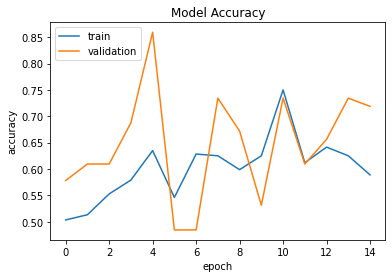

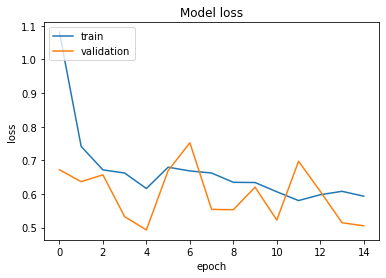

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[INFO] accuracy: 77.69%
[INFO] Loss:  0.5205877423286438


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[74 56]
 [92 38]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.45      0.57      0.50       130
      normal       0.40      0.29      0.34       130

    accuracy                           0.43       260
   macro avg       0.43      0.43      0.42       260
weighted avg       0.43      0.43      0.42       260



In [59]:
from tensorflow.keras.applications import MobileNet
MobileNet = MobileNet(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))
modelfunction(MobileNet,'MobileNet.h5')

83697664/83683744 [==============================] - 0s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
19/19 [==============================] - 11s 401ms/step - loss: 5.5160 - accuracy: 0.4770 - auc_7: 0.4624 - cohen_kappa: -0.9643 - f1_score: 0.4673 - precision_7: 0.4770 - recall_7: 0.4770 - val_loss: 2.0654 - val_accuracy: 0.5469 - val_auc_7: 0.5085 - val_cohen_kappa: -0.6593 - val_f1_score: 0.4298 - val_precision_7: 0.5469 - val_recall_7: 0.5469

Epoch 00001: val_loss improved from inf to 2.06542, saving model to xception.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
19/19 [==============================] - 7s 376ms/step - loss: 1.0216 - accuracy: 0.4901 - auc_7: 0.5302 - cohen_kappa: -0.9951 - f1_score: 0.4889 - precision_7: 0.4901 - recall_7: 0.4901 - val_loss: 0.7461 - val_accuracy: 0.5000 - val_auc_7: 0.4880 - val_cohen_kappa: -0.8221 - val_f1_score: 0.4459 - val_precision_7: 0.5000 - val_recall_7: 0.5000

Epoch 00002: val_loss improved from 2.06542 to 0.74612, saving model to xception.h5
Epoch 3/100
19/19 [==============================] - 7s 348ms/step - loss: 0.7762 - accuracy: 0.5921 - auc_7: 0.6411 - cohen_kappa: -0.8255 - f1_score: 0.5490 - precision_7: 0.5921 - recall_7: 0.5921 - val_loss: 0.7794 - val_accuracy: 0.5469 - val_auc_7: 0.5762 - val_cohen_kappa: -0.9426 - val_f1_score: 0.5331 - val_precision_7: 0.5469 - val_recall_7: 0.5469

Epoch 00003: val_loss did not improve from 0.74612
Epoch 4/100
19/19 [==============================] - 6s 339ms/step - loss: 0.7290 - accuracy: 0.6053 - auc_7: 0.6415 - cohen_kappa: -0.9100 -

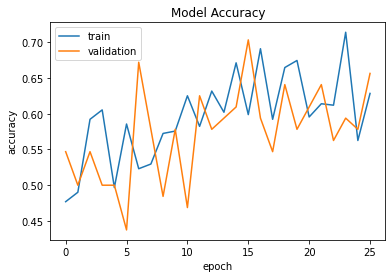

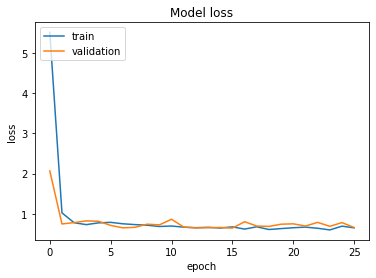

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[INFO] accuracy: 57.69%
[INFO] Loss:  0.7306790947914124


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[59 71]
 [63 67]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.48      0.45      0.47       130
      normal       0.49      0.52      0.50       130

    accuracy                           0.48       260
   macro avg       0.48      0.48      0.48       260
weighted avg       0.48      0.48      0.48       260



In [60]:
from tensorflow.keras.applications import Xception
xception = Xception(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))
modelfunction(xception,'xception.h5')

87924736/87910968 [==============================] - 0s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
19/19 [==============================] - 14s 444ms/step - loss: 20.0778 - accuracy: 0.4967 - auc_8: 0.4954 - cohen_kappa: -0.9176 - f1_score: 0.4741 - precision_8: 0.4967 - recall_8: 0.4967 - val_loss: 2.7935 - val_accuracy: 0.5156 - val_auc_8: 0.6365 - val_cohen_kappa: -0.5799 - val_f1_score: 0.3402 - val_precision_8: 0.5156 - val_recall_8: 0.5156

Epoch 00001: val_loss improved from inf to 2.79346, saving model to Inception.h5
Epoch 2/100
19/19 [==============================] - 6s 325ms/step - loss: 1.4603 - accuracy: 0.5197 - auc_8: 0.5360 - cohen_kappa: -0.9781 - f1_score: 0.5144 - precision_8: 0.5197 - recall_8: 0.5197 - val_loss: 2.1548 - val_accuracy: 0.5000 - val_auc_8: 0.6182 - val_cohen_kappa: -0.6000 - val_f1_score: 0.3333 - val_precision_8: 0.5000 - val_recall_8: 0.5000

Epoch 00002: val_loss improved from 2.79346 to 2.15476, saving model to Inception.h5
Epoch 3/100
19/19 [==============================] - 6s 330ms/step - loss: 1.0257 - accuracy: 0.5625 - auc_8

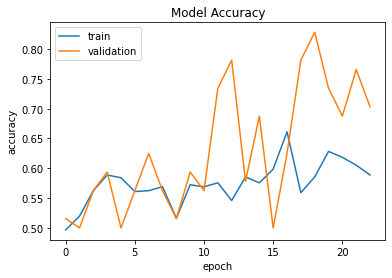

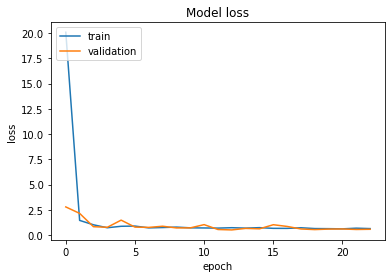

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[INFO] accuracy: 74.62%
[INFO] Loss:  0.5437846183776855


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[61 69]
 [75 55]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.45      0.47      0.46       130
      normal       0.44      0.42      0.43       130

    accuracy                           0.45       260
   macro avg       0.45      0.45      0.45       260
weighted avg       0.45      0.45      0.45       260



In [61]:
from tensorflow.keras.applications import InceptionV3
Inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))
modelfunction(Inception,'Inception.h5')

29097984/29084464 [==============================] - 1s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
19/19 [==============================] - 15s 452ms/step - loss: 1.8248 - accuracy: 0.5230 - auc_9: 0.5178 - cohen_kappa: -0.9126 - f1_score: 0.5002 - precision_9: 0.5230 - recall_9: 0.5230 - val_loss: 0.6362 - val_accuracy: 0.6562 - val_auc_9: 0.7361 - val_cohen_kappa: -0.9692 - val_f1_score: 0.6508 - val_precision_9: 0.6562 - val_recall_9: 0.6562

Epoch 00001: val_loss improved from inf to 0.63624, saving model to DenseNet.h5
Epoch 2/100
19/19 [==============================] - 6s 334ms/step - loss: 0.7658 - accuracy: 0.5592 - auc_9: 0.5775 - cohen_kappa: -0.8938 - f1_score: 0.5330 - precision_9: 0.5592 - recall_9: 0.5592 - val_loss: 0.7318 - val_accuracy: 0.5469 - val_auc_9: 0.5469 - val_cohen_kappa: -0.8380 - val_f1_score: 0.5031 - val_precision_9: 0.5469 - val_recall_9: 0.5469

Epoch 00002: val_loss did not improve from 0.63624
Epoch 3/100
19/19 [==============================] - 6s 320ms/step - loss: 0.7037 - accuracy: 0.5658 - auc_9: 0.5760 - cohen_kappa: -0.9298 - f1

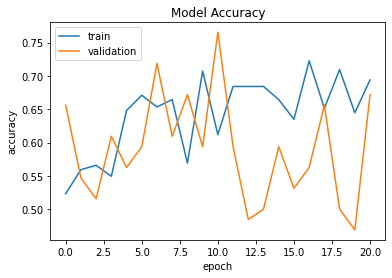

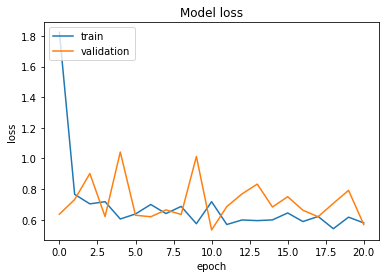

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[INFO] accuracy: 73.46%
[INFO] Loss:  0.548095166683197


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[49 81]
 [50 80]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.49      0.38      0.43       130
      normal       0.50      0.62      0.55       130

    accuracy                           0.50       260
   macro avg       0.50      0.50      0.49       260
weighted avg       0.50      0.50      0.49       260



In [62]:
from tensorflow.keras.applications import DenseNet121
DenseNet = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))
modelfunction(DenseNet,'DenseNet.h5')

219070464/219055592 [==============================] - 1s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
19/19 [==============================] - 22s 577ms/step - loss: 98.5465 - accuracy: 0.5263 - auc_10: 0.5223 - cohen_kappa: -0.9388 - f1_score: 0.5109 - precision_10: 0.5263 - recall_10: 0.5263 - val_loss: 56.3070 - val_accuracy: 0.5469 - val_auc_10: 0.5469 - val_cohen_kappa: -0.5396 - val_f1_score: 0.3535 - val_precision_10: 0.5469 - val_recall_10: 0.5469

Epoch 00001: val_loss improved from inf to 56.30701, saving model to InceptionResNet.h5
Epoch 2/100
19/19 [==============================] - 8s 403ms/step - loss: 19.0236 - accuracy: 0.5461 - auc_10: 0.5181 - cohen_kappa: -0.8454 - f1_score: 0.5045 - precision_10: 0.5461 - recall_10: 0.5461 - val_loss: 8.2201 - val_accuracy: 0.4375 - val_auc_10: 0.4375 - val_cohen_kappa: -0.6787 - val_f1_score: 0.3043 - val_precision_10: 0.4375 - val_recall_10: 0.4375

Epoch 00002: val_loss improved from 56.30701 to 8.22013, saving model to InceptionResNet.h5
Epoch 3/100
19/19 [==============================] - 8s 396ms/step - loss: 3.334

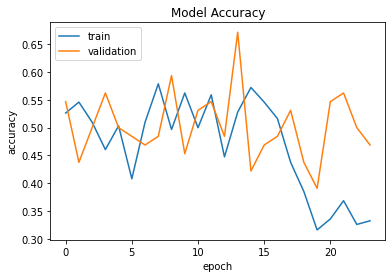

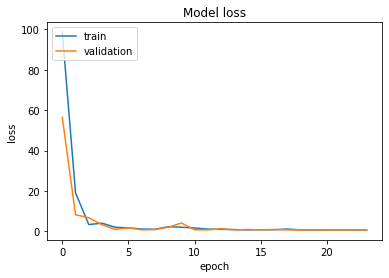

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[INFO] accuracy: 50.00%
[INFO] Loss:  0.8895184397697449


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[130   0]
 [130   0]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.50      1.00      0.67       130
      normal       0.00      0.00      0.00       130

    accuracy                           0.50       260
   macro avg       0.25      0.50      0.33       260
weighted avg       0.25      0.50      0.33       260



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:

from tensorflow.keras.applications import InceptionResNetV2
InceptionResNet = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))
modelfunction(InceptionResNet,'InceptionResNet.h5')

258088960/258076736 [==============================] - 1s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
19/19 [==============================] - 32s 703ms/step - loss: 0.7983 - accuracy: 0.5461 - auc_11: 0.5676 - cohen_kappa: -0.8881 - f1_score: 0.5175 - precision_11: 0.5461 - recall_11: 0.5461 - val_loss: 0.6128 - val_accuracy: 0.6250 - val_auc_11: 0.7802 - val_cohen_kappa: -0.7886 - val_f1_score: 0.5748 - val_precision_11: 0.6250 - val_recall_11: 0.6250

Epoch 00001: val_loss improved from inf to 0.61282, saving model to EfficientNetB7.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
19/19 [==============================] - 7s 379ms/step - loss: 0.6323 - accuracy: 0.6502 - auc_11: 0.6927 - cohen_kappa: -0.9737 - f1_score: 0.6454 - precision_11: 0.6502 - recall_11: 0.6502 - val_loss: 0.3971 - val_accuracy: 0.8750 - val_auc_11: 0.9037 - val_cohen_kappa: -0.9922 - val_f1_score: 0.8745 - val_precision_11: 0.8750 - val_recall_11: 0.8750

Epoch 00002: val_loss improved from 0.61282 to 0.39707, saving model to EfficientNetB7.h5
Epoch 3/100
19/19 [==============================] - 7s 374ms/step - loss: 0.5928 - accuracy: 0.6711 - auc_11: 0.7456 - cohen_kappa: -0.9298 - f1_score: 0.6586 - precision_11: 0.6711 - recall_11: 0.6711 - val_loss: 0.3786 - val_accuracy: 0.8906 - val_auc_11: 0.9631 - val_cohen_kappa: -0.9208 - val_f1_score: 0.8859 - val_precision_11: 0.8906 - val_recall_11: 0.8906

Epoch 00003: val_loss improved from 0.39707 to 0.37864, saving model to EfficientNetB7.h5
Epoch 4/100
19/19 [==============================] - 7s 359ms/step - loss: 0.5441 - 

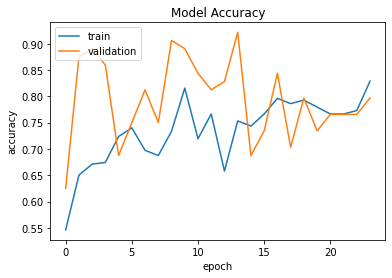

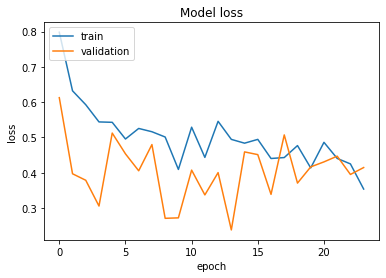

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[INFO] accuracy: 85.38%
[INFO] Loss:  0.3109425902366638


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[64 66]
 [66 64]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.49      0.49      0.49       130
      normal       0.49      0.49      0.49       130

    accuracy                           0.49       260
   macro avg       0.49      0.49      0.49       260
weighted avg       0.49      0.49      0.49       260



In [64]:
from tensorflow.keras.applications import EfficientNetB7
EfficientNetB7 = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))
modelfunction(EfficientNetB7,'EfficientNetB7.h5') 

94781440/94765736 [==============================] - 0s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
19/19 [==============================] - 11s 393ms/step - loss: 1.6390 - accuracy: 0.5263 - auc_12: 0.5501 - cohen_kappa: -0.9047 - f1_score: 0.5014 - precision_12: 0.5263 - recall_12: 0.5263 - val_loss: 0.9771 - val_accuracy: 0.4844 - val_auc_12: 0.6646 - val_cohen_kappa: -0.6199 - val_f1_score: 0.3263 - val_precision_12: 0.4844 - val_recall_12: 0.4844

Epoch 00001: val_loss improved from inf to 0.97710, saving model to ResNet50.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
19/19 [==============================] - 6s 308ms/step - loss: 0.6865 - accuracy: 0.5789 - auc_12: 0.6349 - cohen_kappa: -0.9388 - f1_score: 0.5652 - precision_12: 0.5789 - recall_12: 0.5789 - val_loss: 0.5082 - val_accuracy: 0.9219 - val_auc_12: 0.9673 - val_cohen_kappa: -0.9612 - val_f1_score: 0.9203 - val_precision_12: 0.9219 - val_recall_12: 0.9219

Epoch 00002: val_loss improved from 0.97710 to 0.50821, saving model to ResNet50.h5
Epoch 3/100
19/19 [==============================] - 6s 313ms/step - loss: 0.6076 - accuracy: 0.6678 - auc_12: 0.7292 - cohen_kappa: -0.9643 - f1_score: 0.6616 - precision_12: 0.6678 - recall_12: 0.6678 - val_loss: 0.3151 - val_accuracy: 0.8906 - val_auc_12: 0.9741 - val_cohen_kappa: -0.9995 - val_f1_score: 0.8906 - val_precision_12: 0.8906 - val_recall_12: 0.8906

Epoch 00003: val_loss improved from 0.50821 to 0.31505, saving model to ResNet50.h5
Epoch 4/100
19/19 [==============================] - 6s 308ms/step - loss: 0.6320 - accuracy: 0.

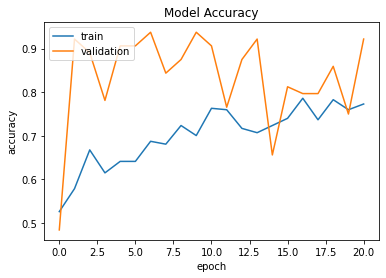

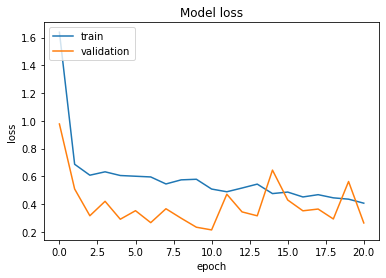

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[INFO] accuracy: 90.38%
[INFO] Loss:  0.23405985534191132


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[71 59]
 [74 56]]
Classification Report
              precision    recall  f1-score   support

    abnormal       0.49      0.55      0.52       130
      normal       0.49      0.43      0.46       130

    accuracy                           0.49       260
   macro avg       0.49      0.49      0.49       260
weighted avg       0.49      0.49      0.49       260



In [65]:
from tensorflow.keras.applications import ResNet50
ResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))
modelfunction(ResNet50,'ResNet50.h5') 

In [66]:
pd.DataFrame.from_dict(l[0])

,loss,accuracy,auc_6,cohen_kappa,f1_score,precision_6,recall_6,val_loss,val_accuracy,val_auc_6,val_cohen_kappa,val_f1_score,val_precision_6,val_recall_6,lr,model
0,1.081059,0.503289,0.498090,-0.976707,"[0.5519288, 0.44280446]",0.503289,0.503289,0.672115,0.578125,0.627930,-0.920750,"[0.47058827, 0.6493507]",0.578125,0.578125,0.0010,MobileNet.h5
1,0.741600,0.513158,0.531759,-0.987612,"[0.5487805, 0.4714286]",0.513158,0.513158,0.636612,0.609375,0.717041,-0.987867,"[0.5762712, 0.6376811]",0.609375,0.609375,0.0010,MobileNet.h5
2,0.671723,0.552632,0.580868,-0.994475,"[0.52777773, 0.575]",0.552632,0.552632,0.656911,0.609375,0.616089,-0.995615,"[0.6268657, 0.59016395]",0.609375,0.609375,0.0010,MobileNet.h5
3,0.662332,0.578947,0.627310,-0.947322,"[0.6384181, 0.496063]",0.578947,0.578947,0.532538,0.687500,0.816406,-1.000000,"[0.6875, 0.6875]",0.687500,0.687500,0.0010,MobileNet.h5
4,0.616271,0.634868,0.696362,-0.890961,"[0.70557034, 0.51948047]",0.634868,0.634868,0.493117,0.859375,0.894531,-0.987867,"[0.8695652, 0.8474576]",0.859375,0.859375,0.0010,MobileNet.h5
5,0.679664,0.546053,0.553541,-0.975292,"[0.59171593, 0.48888886]",0.546053,0.546053,0.669437,0.484375,0.625488,-0.619933,"[0.6526316, 0.0]",0.484375,0.484375,0.0010,MobileNet.h5
6,0.668535,0.628289,0.672973,-0.927401,"[0.6887052, 0.53877556]",0.628289,0.628289,0.752311,0.484375,0.601807,-0.805598,"[0.61176467, 0.23255816]",0.484375,0.484375,0.0010,MobileNet.h5
7,0.662293,0.625000,0.662521,-0.983176,"[0.6566265, 0.58695656]",0.625000,0.625000,0.554163,0.734375,0.822632,-0.976357,"[0.7017544, 0.76056343]",0.734375,0.734375,0.0010,MobileNet.h5
8,0.634733,0.598684,0.663332,-0.999654,"[0.5933333, 0.6038961]",0.598684,0.598684,0.553160,0.671875,0.778564,-0.995615,"[0.6865672, 0.6557377]",0.671875,0.671875,0.0010,MobileNet.h5
9,0.634047,0.625000,0.701177,-0.904699,"[0.6935484, 0.5169492]",0.625000,0.625000,0.620344,0.531250,0.685303,-0.559787,"[0.6938776, 0.0]",0.531250,0.531250,0.0010,MobileNet.h5


In [68]:
pd.DataFrame.from_dict(l[1])

,loss,accuracy,auc_7,cohen_kappa,f1_score,precision_7,recall_7,val_loss,val_accuracy,val_auc_7,val_cohen_kappa,val_f1_score,val_precision_7,val_recall_7,lr,model
0,5.515995,0.476974,0.462431,-0.964271,"[0.53913045, 0.3954373]",0.476974,0.476974,2.065417,0.546875,0.508545,-0.659307,"[0.17142858, 0.68817204]",0.546875,0.546875,0.0010,xception.h5
1,1.021565,0.490132,0.530152,-0.995143,"[0.51410663, 0.4636678]",0.490132,0.490132,0.746117,0.500000,0.488037,-0.822064,"[0.61904764, 0.27272725]",0.500000,0.500000,0.0010,xception.h5
2,0.776164,0.592105,0.641117,-0.825465,"[0.6884422, 0.40952381]",0.592105,0.592105,0.779448,0.546875,0.576172,-0.942613,"[0.61333334, 0.4528302]",0.546875,0.546875,0.0010,xception.h5
3,0.729006,0.605263,0.641534,-0.909974,"[0.67567563, 0.49579832]",0.605263,0.605263,0.823008,0.500000,0.483276,-0.908667,"[0.36, 0.5897436]",0.500000,0.500000,0.0010,xception.h5
4,0.773047,0.496711,0.495937,-0.990501,"[0.5292308, 0.45936397]",0.496711,0.496711,0.812557,0.500000,0.513672,-0.882353,"[0.33333334, 0.6]",0.500000,0.500000,0.0010,xception.h5
5,0.785800,0.585526,0.614666,-0.965963,"[0.6337209, 0.5227273]",0.585526,0.585526,0.710009,0.437500,0.494507,-0.908667,"[0.28, 0.5384615]",0.437500,0.437500,0.0010,xception.h5
6,0.749969,0.523026,0.546026,-0.998249,"[0.5367412, 0.50847465]",0.523026,0.523026,0.649114,0.671875,0.673096,-0.942613,"[0.72, 0.6037736]",0.671875,0.671875,0.0010,xception.h5
7,0.729750,0.529605,0.546139,-0.986565,"[0.5653495, 0.4874552]",0.529605,0.529605,0.662454,0.578125,0.664551,-0.999512,"[0.5846154, 0.5714286]",0.578125,0.578125,0.0010,xception.h5
8,0.714354,0.572368,0.609115,-0.955232,"[0.62857145, 0.49612406]",0.572368,0.572368,0.739984,0.484375,0.535156,-0.961216,"[0.4, 0.54794526]",0.484375,0.484375,0.0010,xception.h5
9,0.682729,0.575658,0.634701,-0.912563,"[0.65040654, 0.46025106]",0.575658,0.575658,0.723366,0.578125,0.613281,-0.805598,"[0.37209302, 0.68235296]",0.578125,0.578125,0.0010,xception.h5


In [69]:
pd.DataFrame.from_dict(l[2])

,loss,accuracy,auc_8,cohen_kappa,f1_score,precision_8,recall_8,val_loss,val_accuracy,val_auc_8,val_cohen_kappa,val_f1_score,val_precision_8,val_recall_8,lr,model
0,20.077761,0.496711,0.495434,-0.917643,"[0.5831063, 0.36514527]",0.496711,0.496711,2.793456,0.515625,0.636475,-0.579942,"[0.68041235, 0.0]",0.515625,0.515625,0.0010,Inception.h5
1,1.460279,0.519737,0.536000,-0.978082,"[0.56547624, 0.4632353]",0.519737,0.519737,2.154759,0.500000,0.618164,-0.600000,"[0.6666667, 0.0]",0.500000,0.500000,0.0010,Inception.h5
2,1.025673,0.562500,0.604246,-0.907353,"[0.6415095, 0.43881857]",0.562500,0.562500,0.836787,0.562500,0.524536,-0.969231,"[0.5, 0.6111111]",0.562500,0.562500,0.0010,Inception.h5
3,0.733566,0.588816,0.622592,-0.861256,"[0.6770026, 0.43438914]",0.588816,0.588816,0.778352,0.593750,0.704834,-0.716681,"[0.71111107, 0.3157895]",0.593750,0.593750,0.0010,Inception.h5
4,0.878445,0.584158,0.611721,-0.872697,"[0.6701571, 0.4375]",0.584158,0.584158,1.486577,0.500000,0.434082,-0.600000,"[0.0, 0.6666667]",0.500000,0.500000,0.0010,Inception.h5
5,0.898699,0.561056,0.535046,-0.942780,"[0.62535214, 0.47011954]",0.561056,0.561056,0.796732,0.562500,0.593018,-0.853394,"[0.39130434, 0.6585366]",0.562500,0.562500,0.0010,Inception.h5
6,0.719314,0.562500,0.607460,-0.984347,"[0.51985556, 0.5981873]",0.562500,0.562500,0.768387,0.625000,0.622070,-0.853394,"[0.47826087, 0.7073171]",0.625000,0.625000,0.0010,Inception.h5
7,0.754119,0.569079,0.583357,-0.867424,"[0.6597402, 0.41255605]",0.569079,0.569079,0.883172,0.562500,0.538452,-0.882353,"[0.4166667, 0.65000004]",0.562500,0.562500,0.0010,Inception.h5
8,0.797344,0.516447,0.542487,-0.912563,"[0.6016261, 0.38493726]",0.516447,0.516447,0.714991,0.515625,0.579834,-0.771243,"[0.6436782, 0.24390244]",0.515625,0.515625,0.0010,Inception.h5
9,0.724563,0.572368,0.625000,-0.962540,"[0.6242774, 0.50381684]",0.572368,0.572368,0.721102,0.593750,0.610229,-0.969231,"[0.5357143, 0.6388889]",0.593750,0.593750,0.0010,Inception.h5


In [70]:
pd.DataFrame.from_dict(l[3])

,loss,accuracy,auc_9,cohen_kappa,f1_score,precision_9,recall_9,val_loss,val_accuracy,val_auc_9,val_cohen_kappa,val_f1_score,val_precision_9,val_recall_9,lr,model
0,1.824839,0.523026,0.517843,-0.912563,"[0.60704607, 0.39330545]",0.523026,0.523026,0.636239,0.656250,0.736084,-0.969231,"[0.60714287, 0.6944444]",0.656250,0.656250,0.0010,DenseNet.h5
1,0.765820,0.559211,0.577535,-0.893770,"[0.64361703, 0.4224138]",0.559211,0.559211,0.731842,0.546875,0.546875,-0.838008,"[0.6506024, 0.35555553]",0.546875,0.546875,0.0010,DenseNet.h5
2,0.703667,0.565789,0.575955,-0.929756,"[0.6353591, 0.46341464]",0.565789,0.565789,0.901722,0.515625,0.472290,-0.659307,"[0.6666666, 0.114285715]",0.515625,0.515625,0.0010,DenseNet.h5
3,0.717704,0.549342,0.555413,-0.999978,"[0.55081964, 0.5478548]",0.549342,0.549342,0.620749,0.609375,0.714844,-0.838008,"[0.44444448, 0.69879514]",0.609375,0.609375,0.0010,DenseNet.h5
4,0.604792,0.648026,0.731702,-0.867424,"[0.72207797, 0.52017933]",0.648026,0.648026,1.042322,0.562500,0.527100,-0.822064,"[0.6666667, 0.36363637]",0.562500,0.562500,0.0010,DenseNet.h5
5,0.637644,0.671053,0.712707,-0.904699,"[0.73118275, 0.57627124]",0.671053,0.671053,0.629256,0.593750,0.684814,-0.908667,"[0.48000005, 0.6666667]",0.593750,0.593750,0.0010,DenseNet.h5
6,0.699578,0.653465,0.638075,-0.938432,"[0.7058824, 0.5783133]",0.653465,0.653465,0.619319,0.718750,0.728271,-0.822064,"[0.78571427, 0.59090906]",0.718750,0.718750,0.0010,DenseNet.h5
7,0.640242,0.664474,0.699506,-0.876467,"[0.73298424, 0.54867256]",0.664474,0.664474,0.664174,0.609375,0.649170,-0.987867,"[0.63768125, 0.57627124]",0.609375,0.609375,0.0010,DenseNet.h5
8,0.687006,0.569079,0.639992,-0.976707,"[0.611276, 0.5166052]",0.569079,0.569079,0.634361,0.671875,0.772705,-0.868187,"[0.7407407, 0.5531915]",0.671875,0.671875,0.0010,DenseNet.h5
9,0.573980,0.707237,0.768574,-0.726482,"[0.7905882, 0.51366127]",0.707237,0.707237,1.012979,0.593750,0.595581,-0.678689,"[0.71739125, 0.2777778]",0.593750,0.593750,0.0010,DenseNet.h5


In [71]:
pd.DataFrame.from_dict(l[4])

,loss,accuracy,auc_10,cohen_kappa,f1_score,precision_10,recall_10,val_loss,val_accuracy,val_auc_10,val_cohen_kappa,val_f1_score,val_precision_10,val_recall_10,lr,model
0,98.546463,0.526316,0.522280,-0.938824,"[0.5977653, 0.424]",0.526316,0.526316,56.307011,0.546875,0.546875,-0.539560,"[0.0, 0.7070707]",0.546875,0.546875,0.0010,InceptionResNet.h5
1,19.023632,0.546053,0.518146,-0.845367,"[0.6479592, 0.36111107]",0.546053,0.546053,8.220131,0.437500,0.437500,-0.678689,"[0.0, 0.6086956]",0.437500,0.437500,0.0010,InceptionResNet.h5
2,3.334740,0.509868,0.475275,-0.967616,"[0.56559765, 0.43773586]",0.509868,0.509868,6.689238,0.500000,0.500000,-0.600000,"[0.6666667, 0.0]",0.500000,0.500000,0.0010,InceptionResNet.h5
3,4.020092,0.460526,0.474182,-0.955232,"[0.53142864, 0.36434105]",0.460526,0.460526,3.280157,0.562500,0.558594,-0.519288,"[0.72, 0.0]",0.562500,0.562500,0.0010,InceptionResNet.h5
4,1.996819,0.503289,0.486117,-0.981964,"[0.5465465, 0.45090908]",0.503289,0.503289,0.922977,0.500000,0.417236,-0.600000,"[0.0, 0.6666667]",0.500000,0.500000,0.0010,InceptionResNet.h5
5,1.704254,0.407895,0.439318,-0.980711,"[0.46107784, 0.34306568]",0.407895,0.407895,1.729544,0.484375,0.452393,-0.619933,"[0.6526316, 0.0]",0.484375,0.484375,0.0010,InceptionResNet.h5
6,1.130770,0.509868,0.509528,-0.896549,"[0.6026667, 0.360515]",0.509868,0.509868,0.738516,0.468750,0.427979,-0.639712,"[0.63829786, 0.0]",0.468750,0.468750,0.0010,InceptionResNet.h5
7,0.996475,0.578947,0.592814,-0.858131,"[0.6701031, 0.41818184]",0.578947,0.578947,0.826964,0.484375,0.364746,-0.619933,"[0.6526316, 0.0]",0.484375,0.484375,0.0010,InceptionResNet.h5
8,2.277053,0.496711,0.488000,-0.896549,"[0.59199995, 0.34334764]",0.496711,0.496711,2.019258,0.593750,0.643066,-0.478700,"[0.0, 0.74509805]",0.593750,0.593750,0.0010,InceptionResNet.h5
9,2.025127,0.562500,0.538965,-0.941003,"[0.62745094, 0.4701195]",0.562500,0.562500,4.095247,0.453125,0.481445,-0.659307,"[0.0, 0.6236559]",0.453125,0.453125,0.0010,InceptionResNet.h5


In [72]:
pd.DataFrame.from_dict(l[5])

,loss,accuracy,auc_11,cohen_kappa,f1_score,precision_11,recall_11,val_loss,val_accuracy,val_auc_11,val_cohen_kappa,val_f1_score,val_precision_11,val_recall_11,lr,model
0,0.798327,0.546053,0.567607,-0.888122,"[0.63492066, 0.4]",0.546053,0.546053,0.612824,0.625000,0.780151,-0.788646,"[0.4285714, 0.7209303]",0.625000,0.625000,0.0010,EfficientNetB7.h5
1,0.632259,0.650165,0.692732,-0.973665,"[0.6863905, 0.60447764]",0.650165,0.650165,0.397070,0.875000,0.903687,-0.992218,"[0.8823529, 0.8666666]",0.875000,0.875000,0.0010,EfficientNetB7.h5
2,0.592845,0.671053,0.745564,-0.929756,"[0.72375685, 0.59349597]",0.671053,0.671053,0.378638,0.890625,0.963135,-0.920750,"[0.86274505, 0.90909094]",0.890625,0.890625,0.0010,EfficientNetB7.h5
3,0.544077,0.674342,0.767389,-0.998249,"[0.6837061, 0.6644068]",0.674342,0.674342,0.305595,0.859375,0.958740,-0.961216,"[0.8767123, 0.8363637]",0.859375,0.859375,0.0010,EfficientNetB7.h5
4,0.542961,0.723684,0.792796,-0.965963,"[0.75581396, 0.6818182]",0.723684,0.723684,0.512464,0.687500,0.798828,-0.908667,"[0.74358976, 0.6]",0.687500,0.687500,0.0010,EfficientNetB7.h5
5,0.495656,0.740132,0.828141,-0.970806,"[0.76832837, 0.70411986]",0.740132,0.740132,0.453544,0.750000,0.878174,-0.908667,"[0.68, 0.7948718]",0.750000,0.750000,0.0010,EfficientNetB7.h5
6,0.525561,0.697368,0.791508,-0.972341,"[0.72941184, 0.6567164]",0.697368,0.697368,0.405536,0.812500,0.895630,-0.969231,"[0.7857142, 0.8333333]",0.812500,0.812500,0.0010,EfficientNetB7.h5
7,0.516255,0.687500,0.786303,-0.995143,"[0.7021944, 0.67128026]",0.687500,0.687500,0.479878,0.750000,0.842407,-0.952336,"[0.7037037, 0.78378385]",0.750000,0.750000,0.0010,EfficientNetB7.h5
8,0.501295,0.733553,0.825355,-0.964271,"[0.76521736, 0.6920152]",0.733553,0.733553,0.270781,0.906250,0.977539,-0.992218,"[0.90000004, 0.9117647]",0.906250,0.906250,0.0010,EfficientNetB7.h5
9,0.409365,0.815789,0.888044,-0.909974,"[0.84864867, 0.7647059]",0.815789,0.815789,0.272086,0.890625,0.955566,-0.920750,"[0.8627451, 0.9090909]",0.890625,0.890625,0.0010,EfficientNetB7.h5


In [73]:
pd.DataFrame.from_dict(l[6])

,loss,accuracy,auc_12,cohen_kappa,f1_score,precision_12,recall_12,val_loss,val_accuracy,val_auc_12,val_cohen_kappa,val_f1_score,val_precision_12,val_recall_12,lr,model
0,1.639037,0.526316,0.550089,-0.904699,"[0.6129032, 0.3898305]",0.526316,0.526316,0.977103,0.484375,0.664551,-0.619933,"[0.6526316, 0.0]",0.484375,0.484375,0.0010,ResNet50.h5
1,0.686544,0.578947,0.634885,-0.938824,"[0.6424581, 0.48800004]",0.578947,0.578947,0.508210,0.921875,0.967285,-0.961216,"[0.9090909, 0.9315069]",0.921875,0.921875,0.0010,ResNet50.h5
2,0.607631,0.667763,0.729203,-0.964271,"[0.70724636, 0.61596954]",0.667763,0.667763,0.315051,0.890625,0.974121,-0.999512,"[0.8923077, 0.8888889]",0.890625,0.890625,0.0010,ResNet50.h5
3,0.632029,0.615132,0.689994,-0.854979,"[0.69922876, 0.4657534]",0.615132,0.615132,0.419232,0.781250,0.881470,-0.716681,"[0.84444445, 0.631579]",0.781250,0.781250,0.0010,ResNet50.h5
4,0.605344,0.641447,0.720768,-0.941003,"[0.6946778, 0.56573707]",0.641447,0.641447,0.289985,0.906250,0.985352,-0.969231,"[0.9166667, 0.89285713]",0.906250,0.906250,0.0010,ResNet50.h5
5,0.600149,0.641447,0.713486,-0.998940,"[0.6495177, 0.6329967]",0.641447,0.641447,0.351528,0.906250,0.955078,-0.952336,"[0.9189189, 0.88888896]",0.906250,0.906250,0.0010,ResNet50.h5
6,0.595033,0.687500,0.753684,-0.917643,"[0.7411444, 0.60580915]",0.687500,0.687500,0.265233,0.937500,0.992188,-0.998049,"[0.9354838, 0.939394]",0.937500,0.937500,0.0010,ResNet50.h5
7,0.544448,0.680921,0.762011,-0.960770,"[0.7204611, 0.62835246]",0.680921,0.680921,0.365571,0.843750,0.911621,-0.882353,"[0.87499994, 0.7916666]",0.843750,0.843750,0.0010,ResNet50.h5
8,0.574002,0.723684,0.791465,-0.965963,"[0.75581396, 0.6818182]",0.723684,0.723684,0.297197,0.875000,0.952881,-0.822064,"[0.90476185, 0.8181818]",0.875000,0.875000,0.0010,ResNet50.h5
9,0.578327,0.700658,0.764229,-0.936610,"[0.746518, 0.6345381]",0.700658,0.700658,0.232281,0.937500,0.981934,-0.908667,"[0.92, 0.9487179]",0.937500,0.937500,0.0010,ResNet50.h5
